In [ ]:
%%capture --no-stderr
%pip install -U langchain langchain_openai langsmith pandas langchain_experimental matplotlib langgraph langchain_core

In [ ]:
import os

LANGCHAIN_TRACING_V2="true"
LANGCHAIN_ENDPOINT="https://api.smith.langchain.com"
LANGCHAIN_API_KEY="langchain_api"
LANGCHAIN_PROJECT="multi-agent"

os.environ["TAVILY_API_KEY"] = "tavily_api"
os.environ["LANGCHAIN_TRACING_V2"] = LANGCHAIN_TRACING_V2
os.environ["LANGCHAIN_ENDPOINT"] = LANGCHAIN_ENDPOINT
os.environ["LANGCHAIN_API_KEY"] = LANGCHAIN_API_KEY
os.environ["LANGCHAIN_PROJECT"] = LANGCHAIN_PROJECT

In [ ]:
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.graph import END, StateGraph, START


def create_agent(llm, tools, system_message: str):
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_tools(tools)

In [ ]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

tavily_tool = TavilySearchResults(max_results=3)
repl = PythonREPL()

@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

In [ ]:
import operator
from typing import Annotated, Sequence
from typing_extensions import TypedDict

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

In [ ]:
%pip install -qU langchain-google-genai langchain-groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 kB 3.7 MB/s eta 0:00:00


In [ ]:
import functools
from langchain_core.messages import AIMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_groq import ChatGroq

os.environ["GOOGLE_API_KEY"] = "GOOGLE_API"
os.environ["GROQ_API_KEY"] = "GROQ_API"

def agent_node(state, agent, name):
    result = agent.invoke(state)
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        "sender": name,
    }

"""
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-pro-002",
)
"""

llm = ChatGroq(
    model="llama-3.2-90b-text-preview",
)
research_agent = create_agent(
    llm,
    [tavily_tool],
    system_message="You should provide accurate data for the chart_generator to use.",
)
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

chart_agent = create_agent(
    llm,
    [python_repl],
    system_message="Any charts you display will be visible by the user.",
)
chart_node = functools.partial(agent_node, agent=chart_agent, name="chart_generator")

In [ ]:
from langgraph.prebuilt import ToolNode

tools = [tavily_tool, python_repl]
tool_node = ToolNode(tools)

In [ ]:
from typing import Literal

def router(state):
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        return END
    return "continue"

In [ ]:
workflow = StateGraph(AgentState)

workflow.add_node("Researcher", research_node)
workflow.add_node("chart_generator", chart_node)
workflow.add_node("call_tool", tool_node)

workflow.add_conditional_edges(
    "Researcher",
    router,
    {"continue": "chart_generator", "call_tool": "call_tool", END: END},
)
workflow.add_conditional_edges(
    "chart_generator",
    router,
    {"continue": "Researcher", "call_tool": "call_tool", END: END},
)

workflow.add_conditional_edges(
    "call_tool",
    lambda x: x["sender"],
    {
        "Researcher": "Researcher",
        "chart_generator": "chart_generator",
    },
)
workflow.add_edge(START, "Researcher")
graph = workflow.compile()

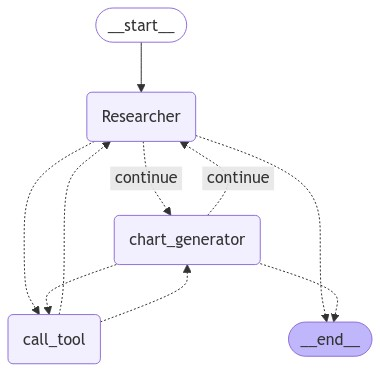

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    pass

In [ ]:
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Fetch the UK's GDP over the past 5 years,"
                " Once you done, finish."
            )
        ],
    },
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")

{'Researcher': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_9d7f', 'function': {'arguments': '{"query": "UK GDP past 5 years"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 408, 'total_tokens': 431, 'completion_time': 0.092, 'prompt_time': 0.074919988, 'queue_time': 0.004184436999999999, 'total_time': 0.166919988}, 'model_name': 'llama-3.2-90b-text-preview', 'system_fingerprint': 'fp_5c5d1b5cfb', 'finish_reason': 'tool_calls', 'logprobs': None}, name='Researcher', id='run-d30e82df-e59e-467d-87ea-c1d73047079a-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'UK GDP past 5 years'}, 'id': 'call_9d7f', 'type': 'tool_call'}], usage_metadata={'input_tokens': 408, 'output_tokens': 23, 'total_tokens': 431})], 'sender': 'Researcher'}}
----
{'call_tool': {'messages': [ToolMessage(content='[{"url": "https://tradingeconomics.com/united-kingdom

In [ ]:
print("FINAL ANSWER: United Kingdom's nominal GDP data over the past 5 years:\n\n 2023: $3340.03 billion \n 2022: $3,088.84B\n 2021: $3,141.51B\n 2020: $2,697.81B")

FINAL ANSWER: United Kingdom's nominal GDP data over the past 5 years:

 2023: $3340.03 billion 
 2022: $3,088.84B
 2021: $3,141.51B
 2020: $2,697.81B
